In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import re
from torchvision import transforms
import json
from sklearn.decomposition import PCA

# 要用git clone 手動下載這個dataset，再移到相對位置

dataset = load_dataset("imagefolder", data_dir="./Dataset/train")

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = self.transform(example["image"])
        label = example["label"]
        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((75, 50)),
    transforms.ToTensor()
])

split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = TransformedDataset(split["train"], transform)
val_dataset = TransformedDataset(split["test"], transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform, label_map):
        self.img_paths = []
        self.labels = []
        self.transform = transform
        self.label_map = label_map

        for file in os.listdir(img_dir):
            if not file.endswith(".png"):
                continue
            label_str = file.split("_")[-1].split(".")[0]
            if label_str.upper() == "UNKNOWN":
                continue
            if label_str not in label_map:
                continue 
            self.img_paths.append(os.path.join(img_dir, file))
            self.labels.append(label_map[label_str])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("L")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label
    
# e.g., {"G1": 0, "M17": 1, ...}
with open("output/label_map.json", "r") as f:
    label_map = json.load(f)
test_dataset = TestDataset(img_dir="./Dataset/test", transform=transform, label_map=label_map)
test_loader = DataLoader(test_dataset, batch_size=64)

class EgyptianCNN(nn.Module):
    def __init__(self, num_classes):
        super(EgyptianCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 17 * 11, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x, return_features=False):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        features = F.relu(self.fc1(x))
        if return_features:
            return features
        return self.fc2(features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_map)
model = EgyptianCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("output/egyptian_cnn_weights.pth", map_location=torch.device("cpu")))
model.eval()

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            feats = model(images, return_features=True)
            features.append(feats.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

X_train_feats, y_train = extract_features(model, train_loader)
X_test_feats, y_test = extract_features(model, test_loader)

components_list = [2, 4, 8, 16, 32]
pca_results = {}

for n_components in components_list:
    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(X_train_feats)
    x_test_pca = pca.transform(X_test_feats)

    pca_results[n_components] = {
        "pca_model": pca,
        "x_train_pca": x_train_pca,
        "x_test_pca": x_test_pca,
    }

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ted12\AppData\Local\Temp\ipykernel_62264\676610786.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# PCA + K-mean clustering

cluster_results = {} 

for n_components, data in pca_results.items():
    x_pca = data["x_train_pca"]

    kmeans = KMeans(n_clusters=10, random_state=42)
    cluster_labels = kmeans.fit_predict(x_pca)

    ari = adjusted_rand_score(y_train, cluster_labels)

    cluster_results[n_components] = {
        "kmeans_model": kmeans,
        "cluster_labels": cluster_labels,
        "ari": ari
    }

    print(f"PCA={n_components}: ARI={ari:.4f}")


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


PCA=2: ARI=0.3465


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


PCA=4: ARI=0.4261


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


PCA=8: ARI=0.4622


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


PCA=16: ARI=0.4646


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


PCA=32: ARI=0.4519


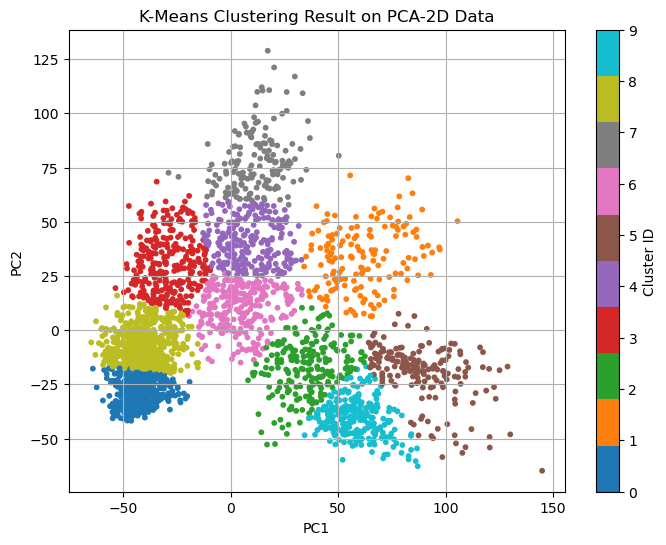

In [ ]:
import matplotlib.pyplot as plt

x_pca = pca_results[2]["x_train_pca"]
cluster_labels = cluster_results[2]["cluster_labels"]

plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("K-Means Clustering Result on PCA-2D Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(label="Cluster ID")
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

# PCA + EM clustering

em_cluster_results = {}

for n_components, data in pca_results.items():
    x_pca = data["x_train_pca"]

    gmm = GaussianMixture(n_components=10, random_state=42)
    gmm.fit(x_pca)
    cluster_labels = gmm.predict(x_pca)

    ari = adjusted_rand_score(y_train, cluster_labels)

    em_cluster_results[n_components] = {
        "gmm_model": gmm,
        "cluster_labels": cluster_labels,
        "ari": ari
    }

    print(f"[GMM] PCA={n_components}: ARI={ari:.4f}")


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


[GMM] PCA=2: ARI=0.3270
[GMM] PCA=4: ARI=0.4202


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


[GMM] PCA=8: ARI=0.4559


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


[GMM] PCA=16: ARI=0.5081


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


[GMM] PCA=32: ARI=0.4837


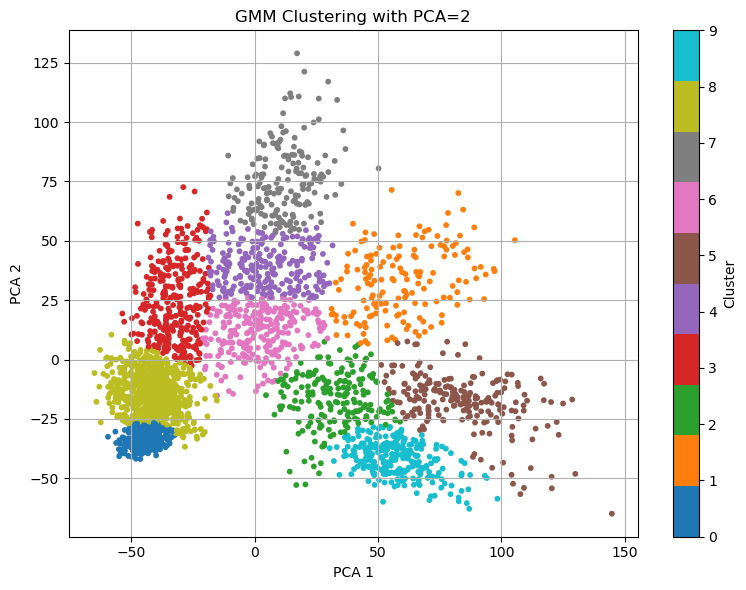

In [ ]:
import matplotlib.pyplot as plt

target_pca_dim = 2
x_pca = pca_results[target_pca_dim]["x_train_pca"]
cluster_labels = em_cluster_results[target_pca_dim]["cluster_labels"]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title(f'GMM Clustering with PCA={target_pca_dim}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# pca + GNB 

all_reports = []

for n_components in components_list:
    print(f"\n=== PCA({n_components}) + GNB 分類 ===")

    x_train_pca = pca_results[n_components]["x_train_pca"]
    x_test_pca = pca_results[n_components]["x_test_pca"]

    gnb = GaussianNB()
    gnb.fit(x_train_pca, y_train)

    y_pred = gnb.predict(x_test_pca)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    report = classification_report(y_test, y_pred, output_dict=True)
    flat_report = {f"{label}_{metric}": score
                   for label, metrics in report.items() if isinstance(metrics, dict)
                   for metric, score in metrics.items()}
    flat_report["accuracy"] = acc
    flat_report["pca_components"] = n_components
    all_reports.append(flat_report)

df = pd.DataFrame(all_reports)
os.makedirs("./results/PCA_GNB", exist_ok=True)
df.to_csv("./results/PCA_GNB/classification_report_all_pca_gnb.csv", index=False)



=== PCA(2) + GNB 分類 ===
Accuracy: 0.4437
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         6
          10       0.21      0.50      0.30        18
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         3
          18       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         2
          25       0.00      0.00      0.00         4
          27       0.00      0.00      0.00         3
          28       0.52      0.71      

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Li

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

all_results = []

for n_components in components_list:
    print(f"\n=== PCA({n_components}) + SVM 分類 ===")

    x_train_pca = pca_results[n_components]["x_train_pca"]
    x_test_pca = pca_results[n_components]["x_test_pca"]

    clf = SVC(kernel='rbf', gamma='scale')
    clf.fit(x_train_pca, y_train)

    y_pred = clf.predict(x_test_pca)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix: PCA({n_components}) + SVM")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join("./results/PCA_SVM", f"cm_pca{n_components}_svm.png"))
    plt.close()

    report = classification_report(y_test, y_pred, output_dict=True)
    flat_report = {
        f"{label}_{metric}": value
        for label, scores in report.items() if isinstance(scores, dict)
        for metric, value in scores.items()
    }
    flat_report["accuracy"] = acc
    flat_report["pca_components"] = n_components
    all_results.append(flat_report)

df = pd.DataFrame(all_results)
df.to_csv(os.path.join("./results/PCA_SVM", "classification_report_all_pca_svm.csv"), index=False)

plt.figure()
plt.plot([r['pca_components'] for r in all_results],
         [r['accuracy'] for r in all_results], marker='o')
plt.title("Accuracy vs PCA Components (CNN feature + SVM)")
plt.xlabel("PCA Components")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join("./results/PCA_SVM", "accuracy_vs_pca.png"))
plt.close()



=== PCA(2) + SVM 分類 ===
Accuracy: 0.4685
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         6
          10       0.27      0.83      0.41        18
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         2
          17       0.00      0.00      0.00         3
          18       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         2
          25       0.00      0.00      0.00         4
          27       0.00      0.00      0.00         3
          28       0.50      0.71      0.59        17
          29       0.00      0.00      0.00         3
          32       0.00      0.00      

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Li


=== PCA(4) + SVM 分類 ===
Accuracy: 0.6126
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.80      0.67      0.73         6
          10       0.35      0.89      0.50        18
          11       0.00      0.00      0.00         1
          13       0.88      0.88      0.88         8
          14       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         2
          17       1.00      0.33      0.50         3
          18       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         0
          22       0.20      0.50      0.29         2
          25       0.00      0.00      0.00         4
          27       0.00      0.00      0.00         3
          28       0.83      0.88      0.86        17
          29       0.00      0.00      

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Li


=== PCA(8) + SVM 分類 ===
Accuracy: 0.7005
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.80      0.67      0.73         6
          10       0.56      1.00      0.72        18
          11       0.50      1.00      0.67         1
          13       0.88      0.88      0.88         8
          14       0.57      1.00      0.73         4
          16       0.67      1.00      0.80         2
          17       1.00      0.33      0.50         3
          18       0.00      0.00      0.00         1
          22       0.67      1.00      0.80         2
          25       0.00      0.00      0.00         4
          27       0.00      0.00      0.00         3
          28       0.81      1.00      0.89        17
          29       0.00      0.00      0.00         3
          32       1.00      1.00      

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Li


=== PCA(16) + SVM 分類 ===
Accuracy: 0.7320
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      0.50      0.67         6
          10       0.75      1.00      0.86        18
          11       0.50      1.00      0.67         1
          13       0.70      0.88      0.78         8
          14       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         2
          17       0.17      0.33      0.22         3
          18       0.00      0.00      0.00         1
          22       0.67      1.00      0.80         2
          25       0.00      0.00      0.00         4
          27       0.00      0.00      0.00         3
          28       0.81      1.00      0.89        17
          29       0.00      0.00      0.00         3
          32       1.00      1.00     

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Li


=== PCA(32) + SVM 分類 ===
Accuracy: 0.7635
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      0.67      0.80         6
          10       0.78      1.00      0.88        18
          11       0.50      1.00      0.67         1
          13       0.70      0.88      0.78         8
          14       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         2
          17       0.20      0.33      0.25         3
          18       0.00      0.00      0.00         1
          22       0.67      1.00      0.80         2
          25       1.00      0.75      0.86         4
          27       0.00      0.00      0.00         3
          28       0.81      1.00      0.89        17
          29       1.00      0.67      0.80         3
          32       1.00      1.00     

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Li